In [2]:
import os

api_key = os.getenv('API_KEY')

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key = api_key)
project = rf.workspace("my-workspace-k3vyu").project("solar-panel-segmentation-ilpfu")
version = project.version(2)
dataset = version.download("coco-segmentation")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to solar-panel-segmentation-2 in coco-segmentation:: 100%|██████████| 798/798 [00:00<00:00, 4952.66it/s]


In [7]:
import json
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [8]:
def load_test_data(image_dir, annotation_file, image_size=(256, 256)):
    with open(annotation_file) as f:
        coco_data = json.load(f)

    images = []
    masks = []

    print("Loading data...\n")

    image_file_names = {img_info['file_name']: img_info['id'] for img_info in coco_data['images']}

    for img_info in coco_data['images']:
        img_file_name = img_info['file_name']
        img_path = os.path.join(image_dir, img_file_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img_to_array(img) / 255.0

        mask = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)

        for anno in coco_data['annotations']:
            if anno['image_id'] == img_info['id']:
                mask = process_and_draw_mask(mask, anno['segmentation'], image_size)

        masks.append(mask)
        images.append(img)

    print("\nData loading complete.\n")
    return np.array(images), np.array(masks)

In [9]:
def process_and_draw_mask(mask, segmentation, image_size=(256, 256)):
    """Segmentasyonu maskeye çizer ve maskeyi yeniden boyutlandırır."""
    if isinstance(segmentation, list):  # Poligon segmentasyonu
        mask = draw_polygon_mask(mask, segmentation, image_size)
    elif isinstance(segmentation, dict) and 'counts' in segmentation:
        mask = rle_decode(segmentation['counts'], shape=image_size)
    return mask

In [10]:
def draw_polygon_mask(mask, segmentation, image_size=(256, 256)):
    """Poligon segmentasyonlarını maskeye çizer ve boyutlandırır."""
    for seg in segmentation:
        poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)

        poly[:, :, 0] = np.clip(poly[:, :, 0], 0, image_size[1]-1)
        poly[:, :, 1] = np.clip(poly[:, :, 1], 0, image_size[0]-1)

        cv2.fillPoly(mask, [poly], 1)
    return mask

Loading data...


Data loading complete.

Visualizing Sample 1:
 - Image Shape: (256, 256, 3)
 - Mask Shape: (256, 256)


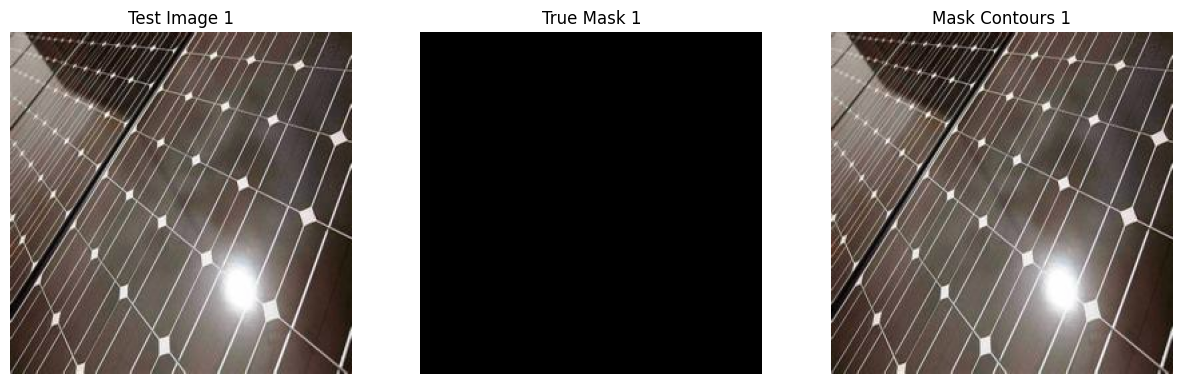

Visualizing Sample 2:
 - Image Shape: (256, 256, 3)
 - Mask Shape: (256, 256)


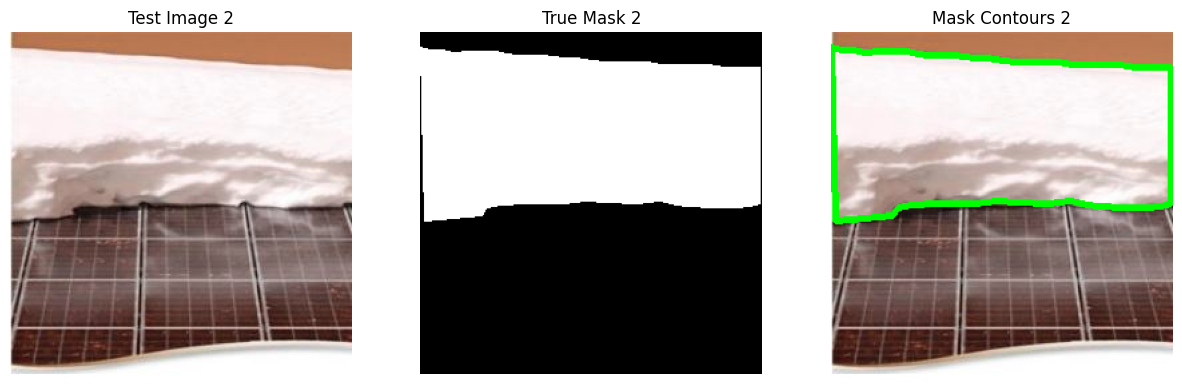

Visualizing Sample 3:
 - Image Shape: (256, 256, 3)
 - Mask Shape: (256, 256)


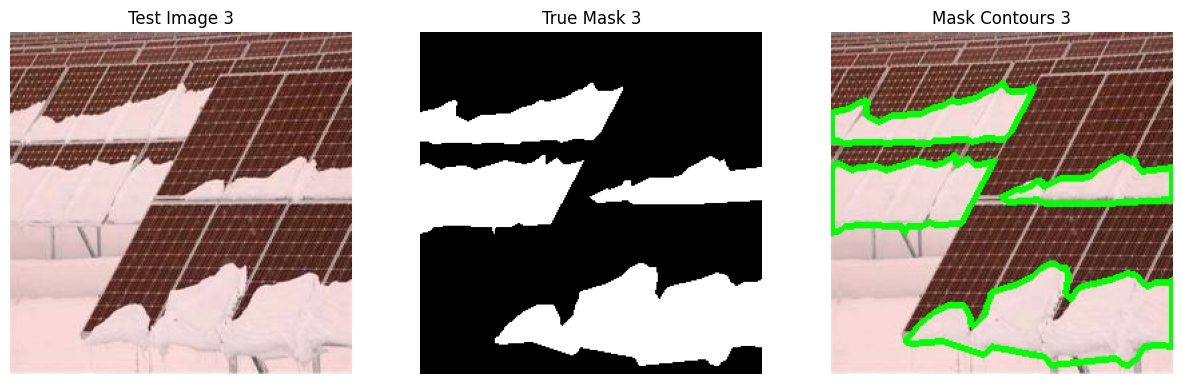

Visualizing Sample 4:
 - Image Shape: (256, 256, 3)
 - Mask Shape: (256, 256)


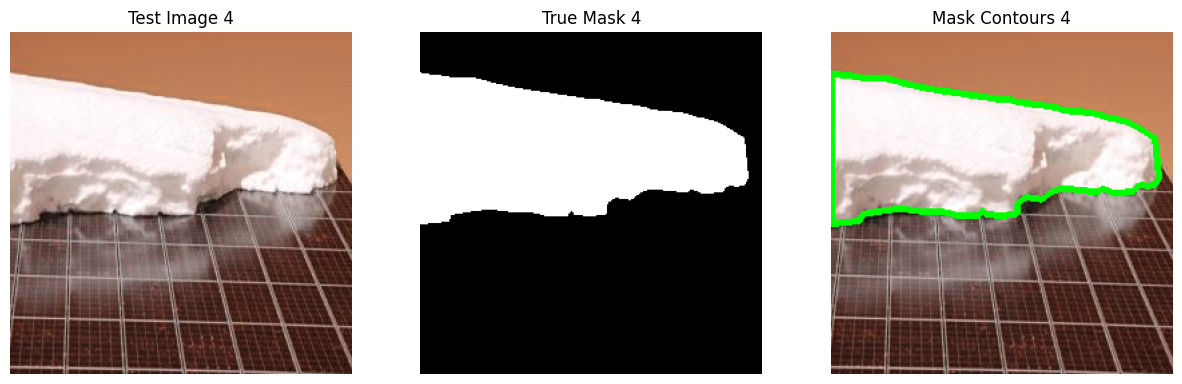

Visualizing Sample 5:
 - Image Shape: (256, 256, 3)
 - Mask Shape: (256, 256)


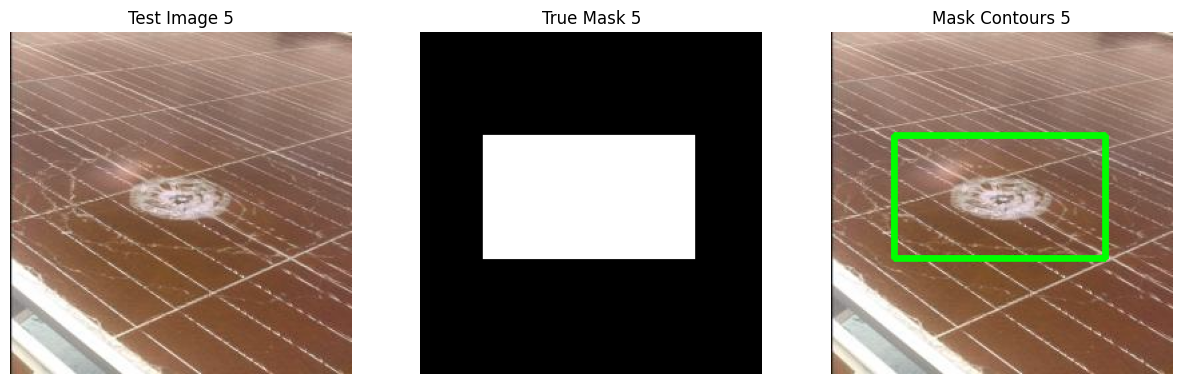

In [11]:
def visualize_test_samples(X, Y, num_samples=5):
    """Test görselleri ve maskelerini görselleştir."""
    for i in range(num_samples):
        print(f"Visualizing Sample {i+1}:")
        print(f" - Image Shape: {X[i].shape}")
        print(f" - Mask Shape: {Y[i].shape}")

        plt.figure(figsize=(15,5))

        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title(f"Test Image {i+1}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(Y[i], cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')

        contours, _ = cv2.findContours(Y[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            cv2.drawContours(X[i], [contour], -1, (0, 255, 0), 3)

        plt.subplot(1, 3, 3)
        plt.imshow(X[i])
        plt.title(f"Mask Contours {i+1}")
        plt.axis('off')

        plt.show()

test_image_dir = '/content/data/test'
test_annotation_file = '/content/data/test/_annotations.coco.json'
X_test, Y_test = load_test_data(test_image_dir, test_annotation_file)

visualize_test_samples(X_test, Y_test)